In [ ]:
# default_exp data.MSResNet

In [ ]:
# export
import os
import cv2
import random
import numpy as np
import torch
import torch.utils.data as data
from skimage.transform import pyramid_gaussian
from defocus.data.common import *

In [ ]:
# export
class Dataset(data.Dataset):
    # Seungjun's defaults for augmentations
    # https://github.com/SeungjunNah/DeepDeblur-PyTorch/blob/master/src/data/common.py
    def __init__(self, root_folder, image_pair_list,
                 mode='train', 
                 augmentations={'hflip':0.5, 
                                'vflip':0.0, 
                                'rot90':0.5, 
                                'channel_shuffle':True, 
                                'saturation':True},
                 crop_size=256,
                 pyramid_scales=3,
                 ):
        super(Dataset, self).__init__()
        
        self.mode = mode
        self.augmentations = augmentations
        self.crop_size = 256
        self.pyramid_scales = pyramid_scales
        input_list = []
        target_list = []
        with open(image_pair_list, 'r') as f:
            for line in f:
                input_filename = line.split(' ')[0].strip('\n').strip('\t')
                target_filename = line.split(' ')[1].strip('\n').strip('\t')
                input_filepath = os.path.join(root_folder, input_filename)
                target_filepath = os.path.join(root_folder, target_filename)
                input_list.append(input_filepath)
                target_list.append(target_filepath)
        self.input_list = input_list
        self.target_list = target_list
        assert len(self.input_list) == len(self.target_list)
        self.length = len(self.input_list)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # remember that opencv has BGR order so read and convert
        input_ = cv2.imread(self.input_list[idx])[:,:,::-1]
        target = cv2.imread(self.target_list[idx])[:,:,::-1]
        
        # if testing, do nothing
        if self.mode=='test' or self.mode=='validation':
            pass
        else:
            H, W, C = input_.shape
            patch_y = random.randrange(0, H-self.crop_size+1)
            patch_x = random.randrange(0, W-self.crop_size+1)
            input_ = crop(input_, patch_x, patch_y)
            target = crop(target, patch_x, patch_y)
        
            # write all augmentations explicitly. why not?
            if random.random() < self.augmentations['hflip']:
                input_ = hflip(input_)
                target = hflip(target)
            if random.random() < self.augmentations['vflip']:
                input_ = vflip(input_)
                target = vflip(target)
            if random.random() < self.augmentations['rot90']:
                # clockwise/counter-clockwise
                if random.random() < 0.5:
                    input_ = vflip(input_)
                    target = vflip(target)
                input_ = rot90(input_)
                target = rot90(target)
            if self.augmentations['channel_shuffle']:
                # note that this is actually a lower probability
                # e.g. shuffled order may just be [0,1,2] again
                rgb_order = [0,1,2]
                random.shuffle(rgb_order)
                input_ = channel_shuffle(input_, rgb_order)
                target = channel_shuffle(target, rgb_order)            
            if self.augmentations['saturation']:
                # Seungjun's defaults
                modifier = random.uniform(0.5, 1.5)
                input_ = saturation(input_, modifier)
                target = saturation(target, modifier)
            # noise only for the input
            # remember the GAN diffaug thing, may help if noise addition is non-leaky?
            input_ = add_gaussian_noise(input_)
            
        # now generate a pyramid of images:
        input_ = input_.astype(np.float32)
        target = target.astype(np.float32)
        # note the order reversal. we are providing the coarsest image as input_pyramid[0]
        # and the original resolution as the last, i.e. input_pyramid[2]
        input_pyramid = list(pyramid_gaussian(input_, self.pyramid_scales-1, multichannel=True))[::-1]
        target_pyramid = list(pyramid_gaussian(target, self.pyramid_scales-1, multichannel=True))[::-1]
        
        # convert to tensors
        # ugly, but explicit
        input_ = []
        target = []
        for scaled_input, scaled_target in zip(input_pyramid, target_pyramid):
            # ascontiguousarray is safer before tensor conversions
            scaled_input = np.ascontiguousarray(scaled_input.transpose(2, 0, 1))
            scaled_target = np.ascontiguousarray(scaled_target.transpose(2, 0, 1))
            input_.append(torch.from_numpy(scaled_input))
            target.append(torch.from_numpy(scaled_target))
        
        return input_, target

# Sanity check

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dataset = Dataset(root_folder='/storage/projects/all_datasets/GOPRO/train/', 
                  image_pair_list='/storage/projects/all_datasets/GOPRO/train/image_pair_list.txt')

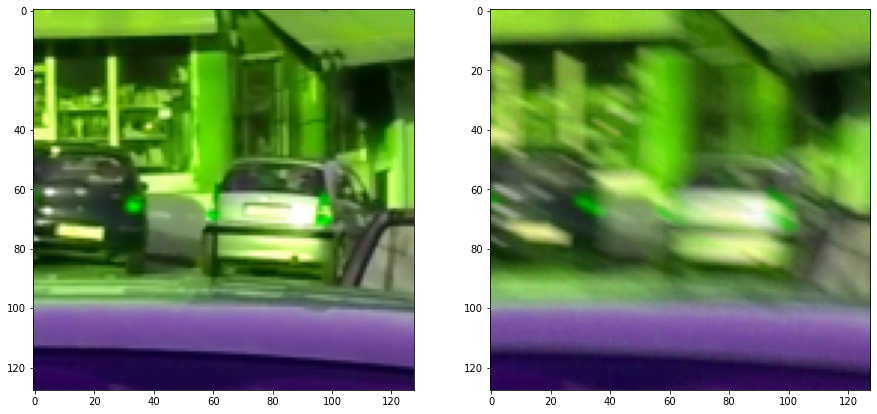

In [ ]:
sample = dataset[0]
target_image = sample['target'][1].numpy().transpose(1,2,0)/255
input_image = sample['input'][1].numpy().transpose(1,2,0)/255
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(target_image)
plt.subplot(122)
plt.imshow(input_image)

# Dataloader test

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler, RandomSampler

In [ ]:
batch_size = 32
sampler = RandomSampler(dataset, replacement=False)
num_workers = 4
drop_last = True
loader = DataLoader(dataset=dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    sampler=sampler,
                    num_workers=num_workers,
                    pin_memory=True,
                    drop_last=drop_last,
                   )

In [ ]:
for sample in loader:
    break

In [ ]:
random_in_batch = random.randint(0, batch_size-1)

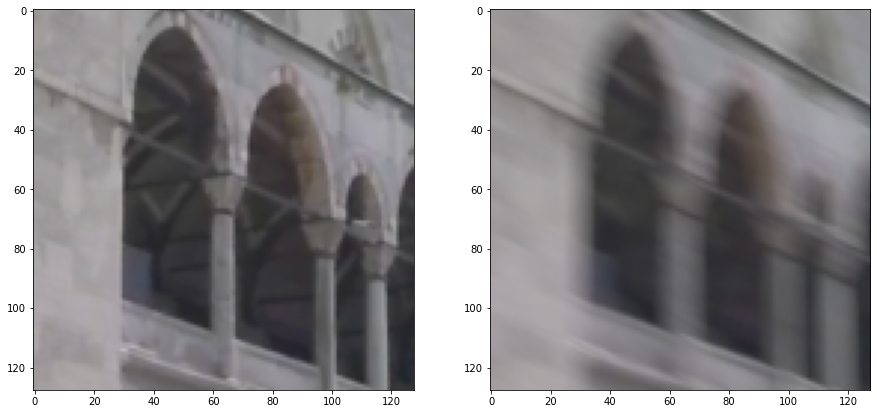

In [ ]:
target_image = sample['target'][1][random_in_batch].numpy().transpose(1,2,0)/255
input_image = sample['input'][1][random_in_batch].numpy().transpose(1,2,0)/255
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(target_image)
plt.subplot(122)
plt.imshow(input_image)

In [ ]:
sample['input'][0][random_in_batch].shape

torch.Size([3, 64, 64])

In [ ]:
from nbdev.export import *
notebook2script()

Converted 01_model.ipynb.
Converted 02_architecture_common.ipynb.
Converted 03_architecture_MSResNet.ipynb.
Converted 04_dataset_common.ipynb.
Converted 05_dataset_MSResNet.ipynb.
Converted 06_trainer_MSResNet.ipynb.
Converted 99_diffaugment.ipynb.
Converted trials.ipynb.
